# Predicting the Success or Failure of  Projects on Kickstarter

Crowdfunding platforms like Kickstarter have provided individuals and organizations with an alternative means of raising funds for their projects. However, not all projects on Kickstarter are successful in reaching their funding goals. In this research, our objective is to determine if we can predict the success or failure of projects on Kickstarter based on the project's characteristics and funding details.

In [2]:
from selenium import webdriver
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.firefox.service import Service
from selenium.webdriver.common.by import By
import time
import json
import csv
import concurrent.futures
import random
import psutil
from selenium.webdriver.common.proxy import Proxy, ProxyType
%matplotlib notebook
import plotly.io as pio
pio.renderers.default = 'notebook'
from plotly.offline import init_notebook_mode
from IPython.display import display, HTML
init_notebook_mode(connected = True)

### Data Acquisition Challenges and Solutions


During the data acquisition process, we encountered challenges that required innovative solutions.One of the challenges was <b>the website blocking our automated tools</b>, which hindered the data gathering process. To overcome this obstacle, <b>we decided to purchase a webShare proxy service, which provided a different IP address for each driver launched (approximately 6000 drivers).</b> This allowed us to bypass the website blocks and collect the necessary data from Kickstarter.


In [3]:
def initialize_driver():
    
    PROXY = "p.webshare.io:9999"
    webdriver.DesiredCapabilities.FIREFOX['proxy'] = {
    "httpProxy": PROXY,
    "sslProxy": PROXY,
    "proxyType": "MANUAL",
    }
    
    firefox_driver_path = "/Users/reembeniluz/Downloads/geckodriver"  
    options.add_argument('-headless')
    options.add_argument("--private")
    driver = webdriver.Firefox(service=Service(firefox_driver_path), options=options)
    print("Driver was created")
    return driver

As a consequence of the website blocking our access due to the use of automated tools, we used proxy servers and launched a separate driver for each attempt to access the website.

In [4]:
def scrape_page(url):
    driver = initialize_driver()
    driver.get(url)
    time.sleep(random.randint(2, 4))
    links = []
    extract_project_links(driver, links)
    driver.quit()
    return links

Another challenge we faced was the complexity of exploring the elements on the webpage, as it was a dynamic page. To overcome this issue, we employed JavaScript injections to capture the required elements

In [5]:
def extract_project_links(driver, links):
    page_links = driver.execute_script("""
        const elements = document.querySelectorAll('div.relative.self-start a[href].block.img-placeholder.w100p');
        const filteredLinks = [];
        elements.forEach(element => {
            const href = element.getAttribute('href');
            if (!href.includes('ref=recommendation-no-result-discoverpage')) {
                filteredLinks.push(href);
            }
        });
        return filteredLinks;
    """)
    links.extend(page_links)

By implementing multi-threaded programming techniques, we were able to expedite the entire process and achieve a remarkable reduction in time. Specifically, we reduced the time required by an impressive 95%, shortening it from 60 hours to just 3 hours.

In [6]:

def projects_links_list_from_website(url, start_page, end_page, links,seed):
    page_seed = seed
    for seed_count in range(1,2):
        page_urls = [url.replace(f'page={start_page}', f'page={page}') for page in range(start_page, end_page+1)]

        with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
            futures = [executor.submit(scrape_page, page_url) for page_url in page_urls]

            for future in concurrent.futures.as_completed(futures):
                result = future.result()
                print(result)
                links.extend(result)
                future.done()

            url = url.replace(f'seed={page_seed}', f'seed={page_seed+1}')
            page_seed += 1
        for future in futures:
            future.result()
    return 


# Dataset Overview


<style>
  ul {
    list-style-type: none;
    padding: 0;
  }

  li {
    margin-bottom: 10px;
    font-size: 16px;
    line-height: 1.4;
  }

  li:before {
    content: "► ";
    color: #ff6600;
    font-weight: bold;
    margin-right: 5px;
  }
</style>

<ul>
  <li>Project Link: The URL of the project on Kickstarter.</li>
  <li>Project Name: The name or title of the project.</li>
  <li>Currency: The currency in which the funding goal and pledged amount are specified.</li>
  <li>Location: The geographical location of the project.</li>
  <li>Parent Category: The overarching category to which the project belongs.</li>
  <li>Category Name: The specific category to which the project belongs.</li>
  <li>Is Project We Love: A binary indicator (Yes/No) representing whether the project is labeled as "Project We Love" by Kickstarter.</li>
  <li>Percent Funded: The percentage of the funding goal that has been achieved.</li>
  <li>Goal Amount: The target amount of funding the project aims to raise.</li>
  <li>Pledged Amount: The amount of funding actually pledged by backers.</li>
  <li>Duration: The duration of the project's fundraising campaign.</li>
  <li>Description Length: The length (in characters) of the project's description.</li>
  <li>Image Count: The number of images associated with the project.</li>
  <li>Video Count: The number of videos associated with the project.</li>
  <li>Risk Desc Count: The length (in characters) of the risk description provided for the project.</li>
  <li>Days Left: The number of days remaining in the project's fundraising campaign.</li>
  <li>Success: A binary label (1/0) indicating whether the project was successful (1) or failed (0).</li>
</ul>


In [7]:
def scrape_project_data(link,driver):
    driver.get(link)
    time.sleep(10)
    try:
        element = driver.find_element(By.XPATH, '//*[@id="react-project-header"]')
        days_left_element = driver.find_element(By.XPATH, '/html/body/main/div/div/div[1]/div/div[1]/div[1]/div[2]/div[2]/div[3]/div/div/span[1]')
        data_initial = element.get_attribute("data-initial")
        json_data = json.loads(data_initial)
        project_name = json_data['project']['name']
        project_link = link
        currency = json_data['project']['currency']
        location = json_data['project']['location']['displayableName']
        try:
            parent_category = json_data['project']['category']['parentCategory']['name']
        except:
            parent_category = 'none'
        category_name = json_data['project']['category']['name']
        is_project_we_love = json_data['project']['isProjectWeLove']
        percent_funded = json_data['project']['percentFunded']
        goal_amount = json_data['project']['goal']['amount']
        pledged_amount = json_data['project']['pledged']['amount']
        duration = json_data['project']['duration']
        description_length = len(json_data['project']['description'])
        video_elements = driver.find_elements(By.TAG_NAME, "video")
        video_count = len(video_elements)
        image_elements = driver.find_elements(By.TAG_NAME, "img")
        image_count = len(image_elements)
        days_left = days_left_element.text

        try:
            riskField = driver.find_element(By.XPATH, '//*[@id="risks-and-challenges"]/p')
            riskDescLength = len(riskField.text)
        except:
            riskDescLength = 0
            
        project_info = {
        "Project Link":project_link,
        "Project Name": project_name,
        "Currency": currency,
        "Location": location,
        "Parent Category": parent_category,
        "Category Name": category_name,
        "Is Project We Love": is_project_we_love,
        "Percent Funded": percent_funded,
        "Goal Amount": goal_amount,
        "Pledged Amount": pledged_amount,
        "Duration": duration,
        "Description Length": description_length,
        "Image Count": image_count,
        "Video Count": video_count,
        "Risk Desc Count": riskDescLength,
        "Days Left":days_left
    }
    except:
        print("problem with link", link)


    return project_info

In [8]:
def projects_data_from_links(links,project_data_dic):
    counter = 1

    def scrape_project_data_wrapper(link):
        driver = initialize_driver()
        try:
            return scrape_project_data(link,driver)
        finally:
            print("Driver Quited")
            driver.quit()
            time.sleep(20)
            
    with concurrent.futures.ThreadPoolExecutor(max_workers=20) as executor:
        futures = [executor.submit(scrape_project_data_wrapper, link) for link in links]
        for future in concurrent.futures.as_completed(futures):
            try:
                result = future.result()
                project_data_dic.append(result)
                print('finished with project:', counter)
                counter += 1
            except:
                print('skipping link')

    return 


In [9]:
def create_csv_table(data, filename):
    fieldnames = [
        "Project Name",
        "Project Link",
        "Parent Category",
        "Category Name",
        "Location",
        "Currency",
        "Goal Amount",
        "Pledged Amount",
        "Percent Funded",
        "Duration",
        "Days Left",
        "Description Length",
        "Risk Desc Count",
        "Is Project We Love",
        "Image Count",
        "Video Count"
    ]
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(data)

In [10]:
def load_list():
    with open("ProjectsLinks.txt", "r") as file:
        links = file.readlines()
        links = [link.strip() for link in links]
    return links

In [11]:
def save_urls_to_file(url_list, filename):
    with open(filename, 'w') as file:
        for url in url_list:
            file.write(url + '\n')
    print(f"URLs saved to '{filename}' successfully.")


In [12]:
def load_csv_into_dict(filename):
    data = []
    with open(filename, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            data.append(row)
    return data

In [13]:
def remove_duplicate_dicts(data):
    unique_data = []
    unique_project_links = set()
    for row in data:
        project_link = row['Project Link']
        if project_link not in unique_project_links:
            unique_data.append(row)
            unique_project_links.add(project_link)
    return unique_data

In [ ]:
projectDict = load_csv_into_dict('projects_table_data_final.csv')
unique_data = remove_duplicate_dicts(projectDict)
create_csv_table(unique_data,'projects_table_data_final.csv')
links=[]
project_data_dic = []
url = "https://www.kickstarter.com/discover/advanced?woe_id=Earth&sort=magic&ref=discovery_overlay&seed=2810541&page=1"
projects_links_list_from_website(url,1,200,links,2810541)

In [ ]:
projects_data_from_links(links,project_data_dic)
create_csv_table(project_data_dic,'projects_table_data.csv')
print('table was created successfuly')

# EDA

Exploratory Data Analysis (EDA) is a fundamental process in predicting the success or failure of projects on Kickstarter. By examining project characteristics and funding details, EDA uncovers patterns and insights within the dataset. It helps identify key factors influencing project outcomes, such as the percentage funded, goal amount, duration, and description length. Through visualizations and statistical analysis, EDA enables researchers to gain a comprehensive understanding of the data, assisting in the development of accurate prediction models.

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


In [15]:
def load_csv_to_dataframe():
    return pd.read_csv("/Users/reembeniluz/DataScienceProj/projects_table_data_final.csv")

To resolve the confusion caused by having countries within the USA listed in the location column during data analysis, a function was created to convert such cells to only contain "USA". The function ensures that the data is consistent and easier to interpret.

In [16]:
def clean_location_col(df):
    state_shortcuts = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY"
}
    df["Location"] = df["Location"].apply(lambda x: 'USA' if any(state in x.split(', ') for state in state_shortcuts.values()) else x.split(', ')[-1].strip())
    return df

In [17]:
def classify_success_col(df):
    df['Success'] = 0
    df.loc[df['Percent Funded'] >= 100, 'Success'] = 1

In [18]:
def boolean_to_numbers(df):
    df['Is Project We Love'] = df['Is Project We Love'].map({False: 0, True: 1})

In [19]:
def targetCol_success_compare(target_col, top_n=20):
    success = df.groupby(target_col)['Success'].mean().sort_values(ascending=False)
    count = df.groupby(target_col)['Success'].count().loc[success.index]
    top_n_categories = success[(success < 1) | (count >= 5)][:top_n]

    fig = px.bar(top_n_categories, x=top_n_categories.index, y=top_n_categories.values,
                 color=top_n_categories.index, color_discrete_sequence=["#1984c5", "#22a7f0", "#63bff0", "#a7d5ed", "#e2e2e2", "#e1a692", "#de6e56", "#e14b31", "#c23728"])

    fig.update_layout(
        title='Success Rate by ' + target_col,
        xaxis=dict(title=target_col),
        yaxis=dict(title='Success Rate'),
        xaxis_tickangle=-45,
        showlegend=False
    )

    fig.show("png")

In [20]:
def create_heatMap():
    colors = ["#1984c5", "#22a7f0", "#63bff0", "#a7d5ed", "#e2e2e2", "#e1a692", "#de6e56", "#e14b31", "#c23728"]
    columns = ['Description Length', 'Goal Amount', 'Duration', 'Risk Desc Count', 'Image Count', 'Video Count', 'Is Project We Love', 'Success']

    location_count = df['Location'].value_counts().reset_index()
    location_count.columns = ['Location', 'Country']
    df_with_location_count = df.merge(location_count, on='Location', how='left')

    columns_with_location_count = columns + ['Country']

    corr_matrix = df_with_location_count[columns_with_location_count].corr()

    fig = px.imshow(corr_matrix, color_continuous_scale=colors)
    fig.update_layout(
        title='Correlation Heatmap',
        xaxis=dict(title='Columns'),
        yaxis=dict(title='Columns'),
        showlegend=False
    )

    fig.show("png")

In [21]:
def create_target_box_graph(target):
    colors = ["#63bff0","#e14b31"]
    fig = px.box(df, x='Success', y=target, color='Success', color_discrete_sequence=colors)

    fig.update_layout(
        title= target + ' Distribution by Project Success',
        xaxis=dict(title='Project Success'),
        yaxis=dict(title=target+'Count'),
        showlegend=False
    )

    fig.show("png")

In [22]:
def create_count_by_category_graph():
    colors = ["#22a7f0", "#63bff0", "#e2e2e2", "#e1a692", "#de6e56", "#e14b31"]

    counts = df['Parent Category'].value_counts().reset_index()
    counts.columns = ['Parent Category', 'Count']

    fig = px.bar(counts, x='Parent Category', y='Count', color='Parent Category', color_discrete_sequence=colors)

    fig.update_layout(
        title='Count of Projects by Parent Category',
        xaxis=dict(title='Parent Category'),
        yaxis=dict(title='Count'),
        showlegend=False,
    )

    fig.show("png")

In [23]:
def create_category_success_distribuition():
    success_by_category = df.groupby(['Parent Category', 'Success']).size().unstack()
    success_by_category = success_by_category.div(success_by_category.sum(axis=1), axis=0) * 100

    colors = ["#de6e56","#63bff0"]
    fig = px.bar(success_by_category, barmode='stack', color_discrete_sequence=colors)

    fig.update_layout(
        title='Distribution of Project Success by Parent Category',
        xaxis=dict(title='Parent Category'),
        yaxis=dict(title='Percentage'),
        legend=dict(title='Success', x=1.0, y=1.0),
        showlegend=True,
        xaxis_tickangle=-45
    )

    fig.show("png")

In [24]:
def create_category_love_distribution():
    success_by_category = df.groupby(['Parent Category', 'Is Project We Love']).size().unstack()
    success_by_category = success_by_category.div(success_by_category.sum(axis=1), axis=0) * 100

    colors = ["#de6e56","#63bff0"]
    fig = px.bar(success_by_category, barmode='stack', color_discrete_sequence=colors)

    fig.update_layout(
        title='Distribution of Project Success by Is Project We Love',
        xaxis=dict(title='Is Project We Love'),
        yaxis=dict(title='Percentage'),
        legend=dict(title='Success', x=1.0, y=1.0),
        showlegend=True,
        xaxis_tickangle=-45
    )

    fig.show("png")


In [25]:
def create_low_goal_percent_funded_graph():
    low_goal_df = df[df['Goal Amount'] < df['Goal Amount'].median()]
    success_by_category = low_goal_df.groupby('Parent Category')['Success'].mean().reset_index()
    median_values = low_goal_df.groupby('Parent Category')['Goal Amount'].median().reset_index()
    success_by_category['Median Goal Amount'] = median_values['Goal Amount']

    fig = px.bar(success_by_category, x='Parent Category', y='Success',
                 title="Success Rate by Parent Category (Low Goal Amount)",
                 labels={'Parent Category': 'Parent Category', 'Success': 'Success Rate'},
                 color_discrete_sequence=['#63bff0'])

    for i, row in success_by_category.iterrows():
        fig.add_annotation(
            x=row['Parent Category'],
            y=row['Success'],
            text=f"{row['Median Goal Amount']}",
            showarrow=False,
            font=dict(color='black'),
            yshift=10
        )

    fig.update_layout(showlegend=False)
    fig.show("png")


In [26]:
def create_high_goal_percent_funded_graph():
    high_goal_df = df[df['Goal Amount'] > df['Goal Amount'].median()]
    success_by_category = high_goal_df.groupby('Parent Category')['Success'].mean().reset_index()
    median_by_category = high_goal_df.groupby('Parent Category')['Goal Amount'].median().reset_index()
    success_by_category['Median Goal Amount'] = median_by_category['Goal Amount']
    fig = px.bar(success_by_category, x='Parent Category', y='Success',
                 title="Success Rate by Parent Category (High Goal Amount)",
                 labels={'Parent Category': 'Parent Category', 'Success': 'Success Rate'},
                 color_discrete_sequence=['#63bff0'])

    for i, row in success_by_category.iterrows():
        fig.add_annotation(
            x=row['Parent Category'],
            y=row['Success'],
            text=f"{row['Median Goal Amount']}",
            showarrow=False,
            font=dict(color='black'),
            yshift=10
        )

    fig.update_layout(showlegend=False)
    fig.show("png")
    

In [27]:
df = load_csv_to_dataframe()

goal_amount_iqr = np.percentile(df['Goal Amount'], 75) - np.percentile(df['Goal Amount'], 25)
lower_bound = np.percentile(df['Goal Amount'], 25) - 1.5 * goal_amount_iqr
upper_bound = np.percentile(df['Goal Amount'], 75) + 1.5 * goal_amount_iqr
df = df[(df['Goal Amount'] >= lower_bound) & (df['Goal Amount'] <= upper_bound)]

goal_amount_iqr = np.percentile(df['Duration'], 75) - np.percentile(df['Duration'], 25)
lower_bound = np.percentile(df['Duration'], 25) - 1.5 * goal_amount_iqr
upper_bound = np.percentile(df['Duration'], 75) + 1.5 * goal_amount_iqr
df = df[(df['Duration'] >= lower_bound) & (df['Duration'] <= upper_bound)]
clean_location_col(df)
classify_success_col(df)
boolean_to_numbers(df)
df.to_csv('handled Table.csv', index=False)


# Visualisation:

This graph visualizes the count of projects by their parent category, showcasing the distribution and relative frequency of projects across different categories:

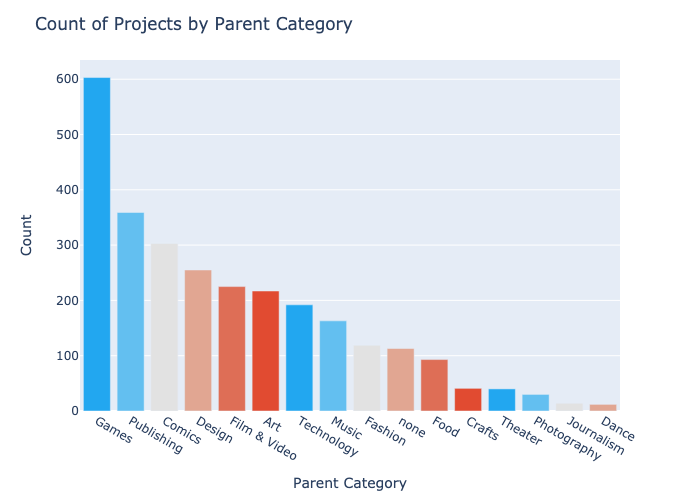

In [28]:
create_count_by_category_graph()

This graph represents the distribution of project success across different parent categories, showcasing the percentage of successful projects compared to unsuccessful ones:

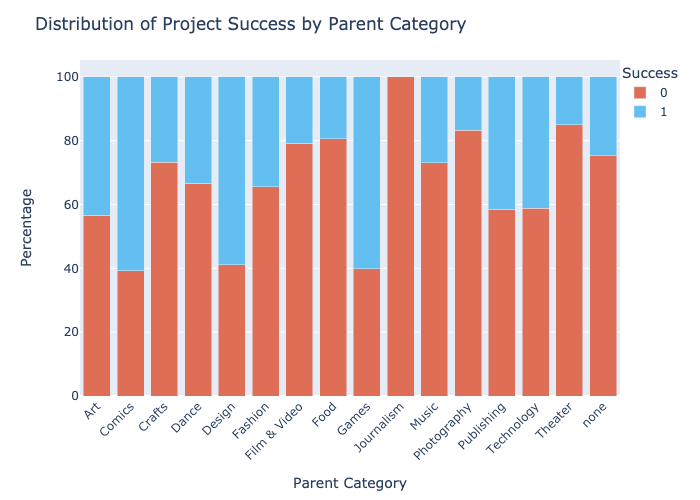

In [29]:
create_category_success_distribuition()

This graph represents the distribution of project success based on whether the project is labeled as "Project We Love":

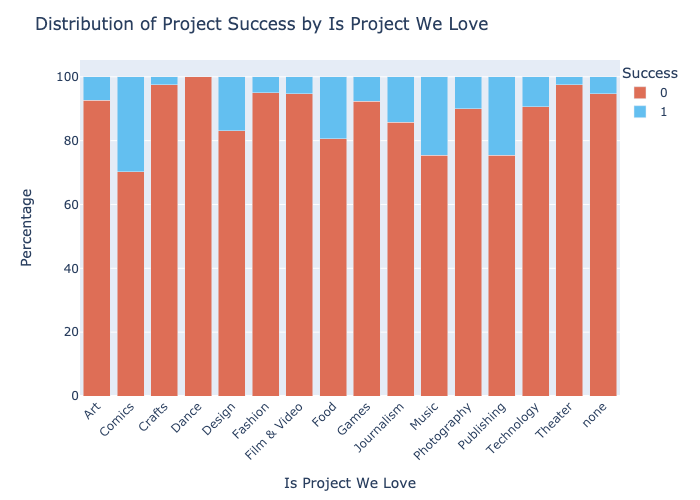

In [30]:
create_category_love_distribution()

The following graphs represent the success rate of different categories based on a specified target column:

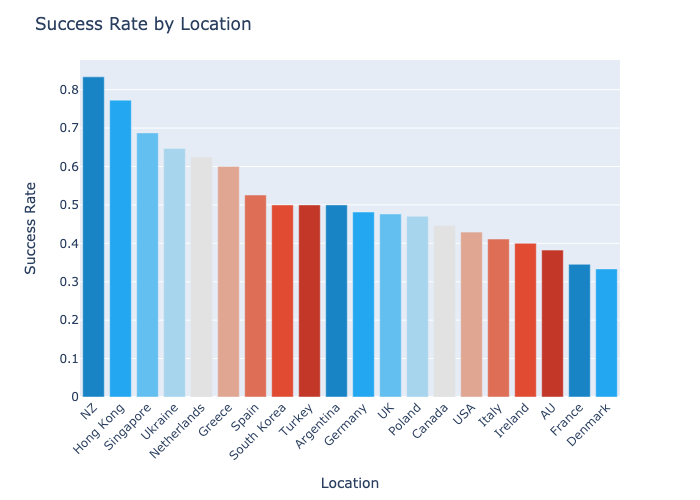

In [31]:
targetCol_success_compare("Location")

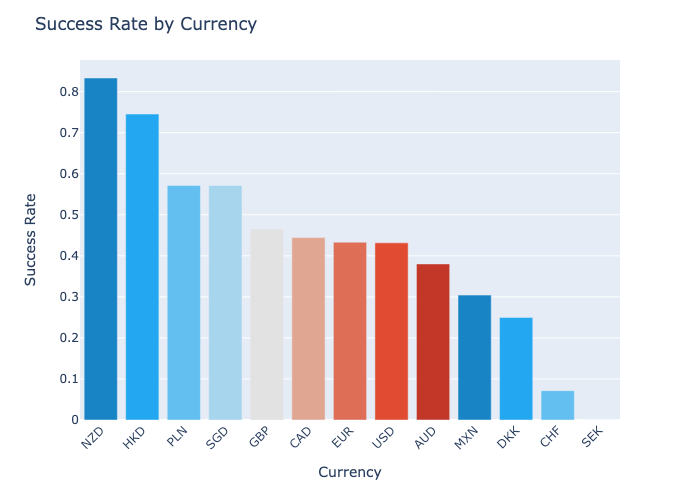

In [32]:
targetCol_success_compare("Currency")

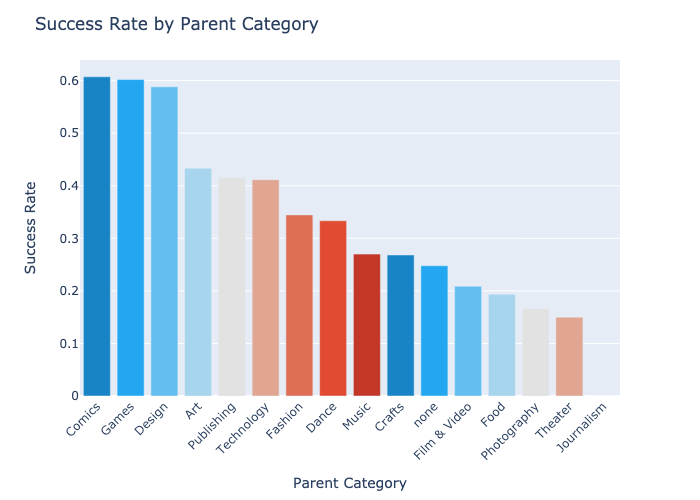

In [33]:
targetCol_success_compare("Parent Category")

This is a correlation heatmap for selected columns in the DataFrame:

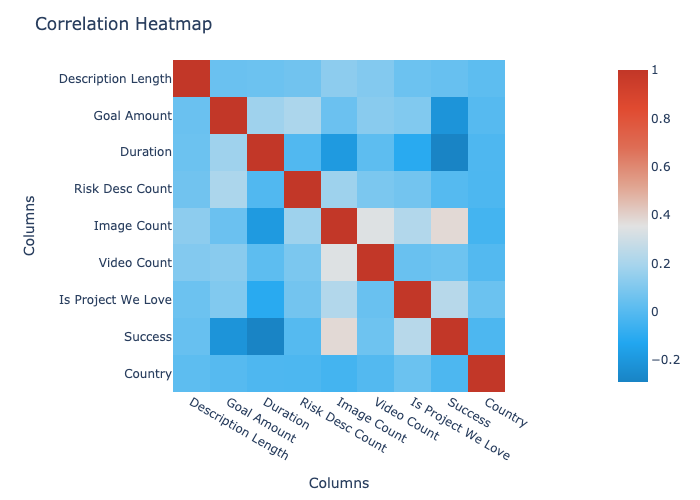

In [34]:
create_heatMap()

The following box plots compare the distribution of a specified target variable based on project success:

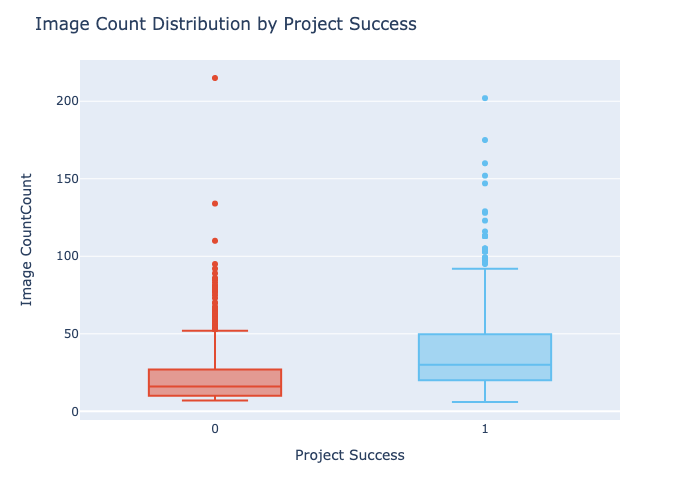

In [35]:
create_target_box_graph('Image Count')

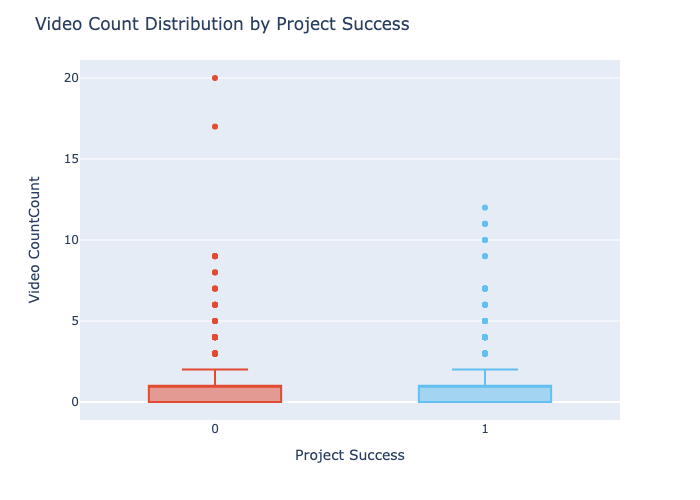

In [36]:
create_target_box_graph('Video Count')

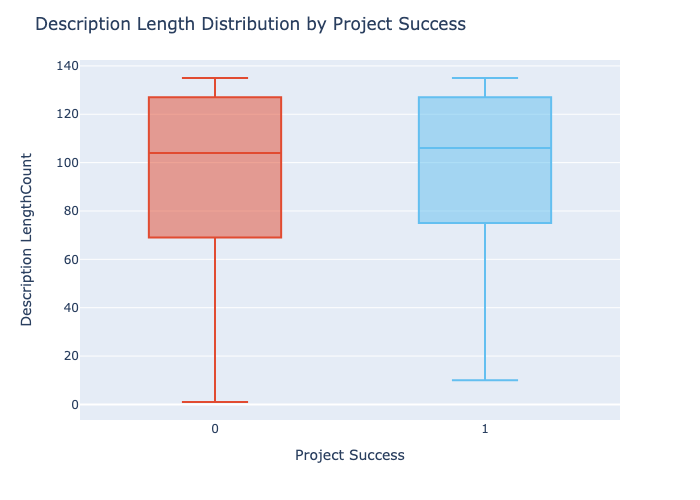

In [37]:
create_target_box_graph('Description Length')

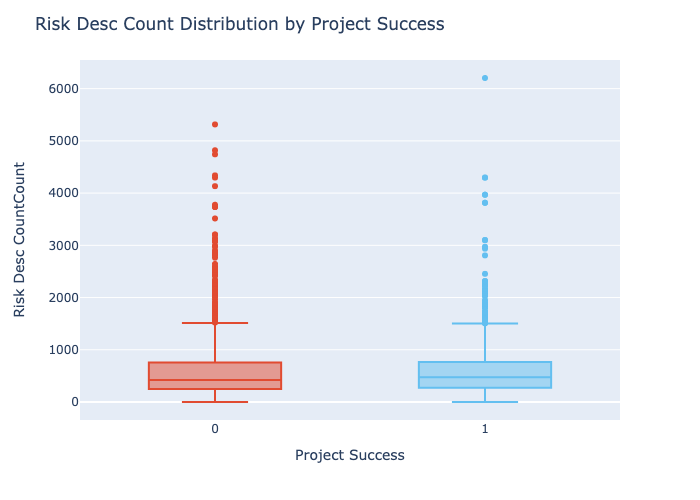

In [38]:
create_target_box_graph('Risk Desc Count')

The following graph represnets the success rate of projects within a specific category when their goal amounts are below the median goal amount:

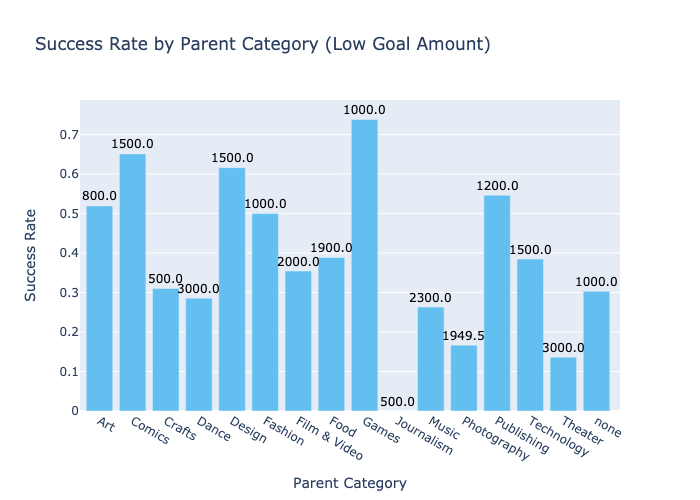

In [39]:
create_low_goal_percent_funded_graph()

The following graph represnets the success rate of projects within a specific category when their goal amounts are above the median goal amount:

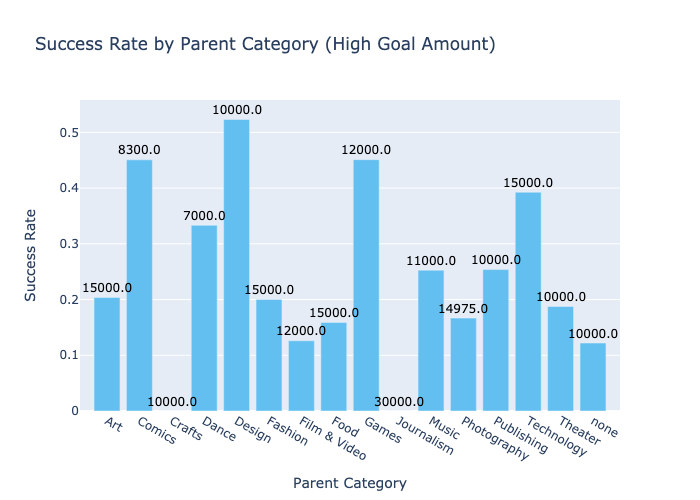

In [40]:
create_high_goal_percent_funded_graph()

## Visulaisation Conclusions

During the visualization of the data, we made the following observations:
The top three most successful categories on Kickstarter were comics, games, and design, while the bottom three were journalism, photography, and theater.
Projects outside of Europe and the USA had the highest success rates on the platform.
The use of a heatmap revealed a strong relationship between the number of images and the success of projects.
All of the projects that succeeded had a photo count ranging from 26 to 52.
Projects with a description length lower than 78 failed to achieve their funding goals.
These findings provide insights into the factors that contribute to the success or failure of projects on Kickstarter and could be utilized to develop predictive models for project outcomes on crowdfunding platforms.

# Machine Learning part

To predict the success or failure of projects on Kickstarter, we employed two machine learning models: linear regression and decision trees.


In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.tree import plot_tree

In [42]:
def load_handled_dataset():
    return pd.read_csv("/Users/reembeniluz/DataScienceProj/handled Table.csv")

# Linear regression

Linear regression is a widely used statistical model that aims to establish a linear relationship between the dependent variable (in our case, project success) and one or more independent variables (project characteristics and funding details). By fitting a regression line to the data, we can make predictions based on the observed values of the independent variables.
In our analysis, we applied linear regression to determine the impact of various project attributes on the likelihood of success or failure. By examining the coefficients associated with each independent variable, we gained insights into the relative importance of different factors in predicting project outcomes

In [43]:
def run_linear_regression_model():
    selected_categories = ['Comics', 'Fashion', 'Photography', 'Film & Video', 'Art', 'none', 'Music',
                           'Publishing', 'Games', 'Technology', 'Food', 'Theater', 'Design', 'Crafts',
                           'Journalism', 'Dance']
    category_markers = {
        'Comics': {'marker': 's'},
        'Fashion': {'marker': 'o'},
        'Photography': {'marker': 'v'},
        'Film & Video': {'marker': 'p'},
        'Art': {'marker': 'h'},
        'none': {'marker': 'x'},
        'Music': {'marker': 'D'},
        'Publishing': {'marker': 's'},
        'Games': {'marker': 'o'},
        'Technology': {'marker': 'v'},
        'Food': {'marker': 'p'},
        'Theater': {'marker': 'h'},
        'Design': {'marker': 'x'},
        'Crafts': {'marker': 'D'},
        'Journalism': {'marker': 's'},
        'Dance': {'marker': 'o'}
    }

    tss = 0
    sse = 0

    fig, ax = plt.subplots(figsize=(10, 6))
    for category in selected_categories:
        category_data = data[(data['Parent Category'] == category) & (data['Goal Amount'] < 300000) & (data['Percent Funded'] < 1000)]
        if len(category_data) > 0:
            ax.scatter(category_data[category_data['Success'] == 1]['Goal Amount'],
                       category_data[category_data['Success'] == 1]['Percent Funded'],
                       color='blue', marker='*', s=100)

            ax.scatter(category_data[category_data['Success'] == 0]['Goal Amount'],
                       category_data[category_data['Success'] == 0]['Percent Funded'],
                       color='red', marker=category_markers[category]['marker'])

        model = LinearRegression()
        X = category_data['Goal Amount'].values.reshape(-1, 1)
        y = category_data['Percent Funded']
        model.fit(X, y)

        coefficient = model.coef_[0]
        intercept = model.intercept_
        y_pred = model.predict(X)
        squared_diff = (y - y_pred) ** 2
        sse = squared_diff.sum()
        mean_percent_funded = np.mean(category_data['Percent Funded'])
        tss = np.sum((category_data['Percent Funded'] - mean_percent_funded) ** 2)
        r_squared = 1 - (sse / tss)
        print(f'Parent Category: {category}')
        print(f'Coefficient: {coefficient}')
        print(f'Intercept: {intercept}')
        print(f'Sum of Squared Errors (SSE): {sse:.4f}')
        print(f'Coefficient of Determination (R-squared): {r_squared:.4f}')

    ax.set_title('Combined Categories - Goal Amount vs Percent Funded')
    ax.set_xlabel('Goal Amount')
    ax.set_ylabel('Percent Funded')

    plt.tight_layout()
    plt.show()


# Decision trees

Decision trees are popular machine learning algorithms that can be used for both classification and regression tasks. These models create a hierarchical structure of decision nodes and leaf nodes, where each decision node represents a feature or attribute, and each leaf node represents a class label.
By constructing a decision tree based on our dataset, we aimed to identify the decision rules that best distinguish successful and failed projects on Kickstarter. The resulting tree can be used to make predictions for new projects by following the path from the root node to a leaf node, which corresponds to the predicted class label.

In [44]:
def run_decision_tree_model():
    X = data[['Goal Amount', 'Duration']]
    y = data['Success']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    decision_tree = DecisionTreeClassifier(max_depth=3)
    decision_tree.fit(X_train, y_train)
    y_pred_train = decision_tree.predict(X_train)
    print('Accuracy on training data = ', metrics.accuracy_score(y_train, y_pred_train))
    y_pred = decision_tree.predict(X_test)
    print('Accuracy on test data = ', metrics.accuracy_score(y_test, y_pred))
    plt.figure(figsize=(12, 6))
    plot_tree(decision_tree, feature_names=X.columns, class_names=['fail', 'success'], filled=True)
    plt.show()


In [45]:
def run_improved_decision_tree_model():
    X = data[[ 'Duration','Is Project We Love','Image Count', 'Goal Amount']]
    y = data['Success']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    decision_tree = DecisionTreeClassifier(max_depth=4)
    decision_tree.fit(X_train, y_train)
    y_pred_train = decision_tree.predict(X_train)
    print('Accuracy on training data = ', metrics.accuracy_score(y_train, y_pred_train))
    y_pred = decision_tree.predict(X_test)
    print('Accuracy on test data = ', metrics.accuracy_score(y_test, y_pred))
    plt.figure(figsize=(48, 24))
    plot_tree(decision_tree, feature_names=X.columns, class_names=['fail', 'success'], filled=True)
    plt.show()

In [46]:
data = load_handled_dataset();

After analyzing the results of the linear regression model, we saw that the linear relationship between the "Goal Amount" and "Precent Funded" variables in the different parent categories is relatively weak.
The analysis indicates a generally weak association between the goal amount and the percent funded. The coefficients obtained from the linear regression model suggest that as <b>the goal amount increases, the percent funded tends to decrease slightly</b>. However, the magnitude of these coefficients is relatively small, implying a limited impact of the goal amount on the success of crowdfunding campaigns.

Considering these findings, we have decided to explore alternative modeling approaches. One such approach is the decision tree model.
By transitioning to a decision tree model, we aim to capture the underlying complexities and nuances of the crowdfunding data more accurately, potentially improving our predictive performance. This shift in modeling approach will allow us to explore a wider range of variables and interactions, leading to more accurate predictions and a better understanding of the factors that drive campaign success in different parent categories.

<IPython.core.display.Javascript object>


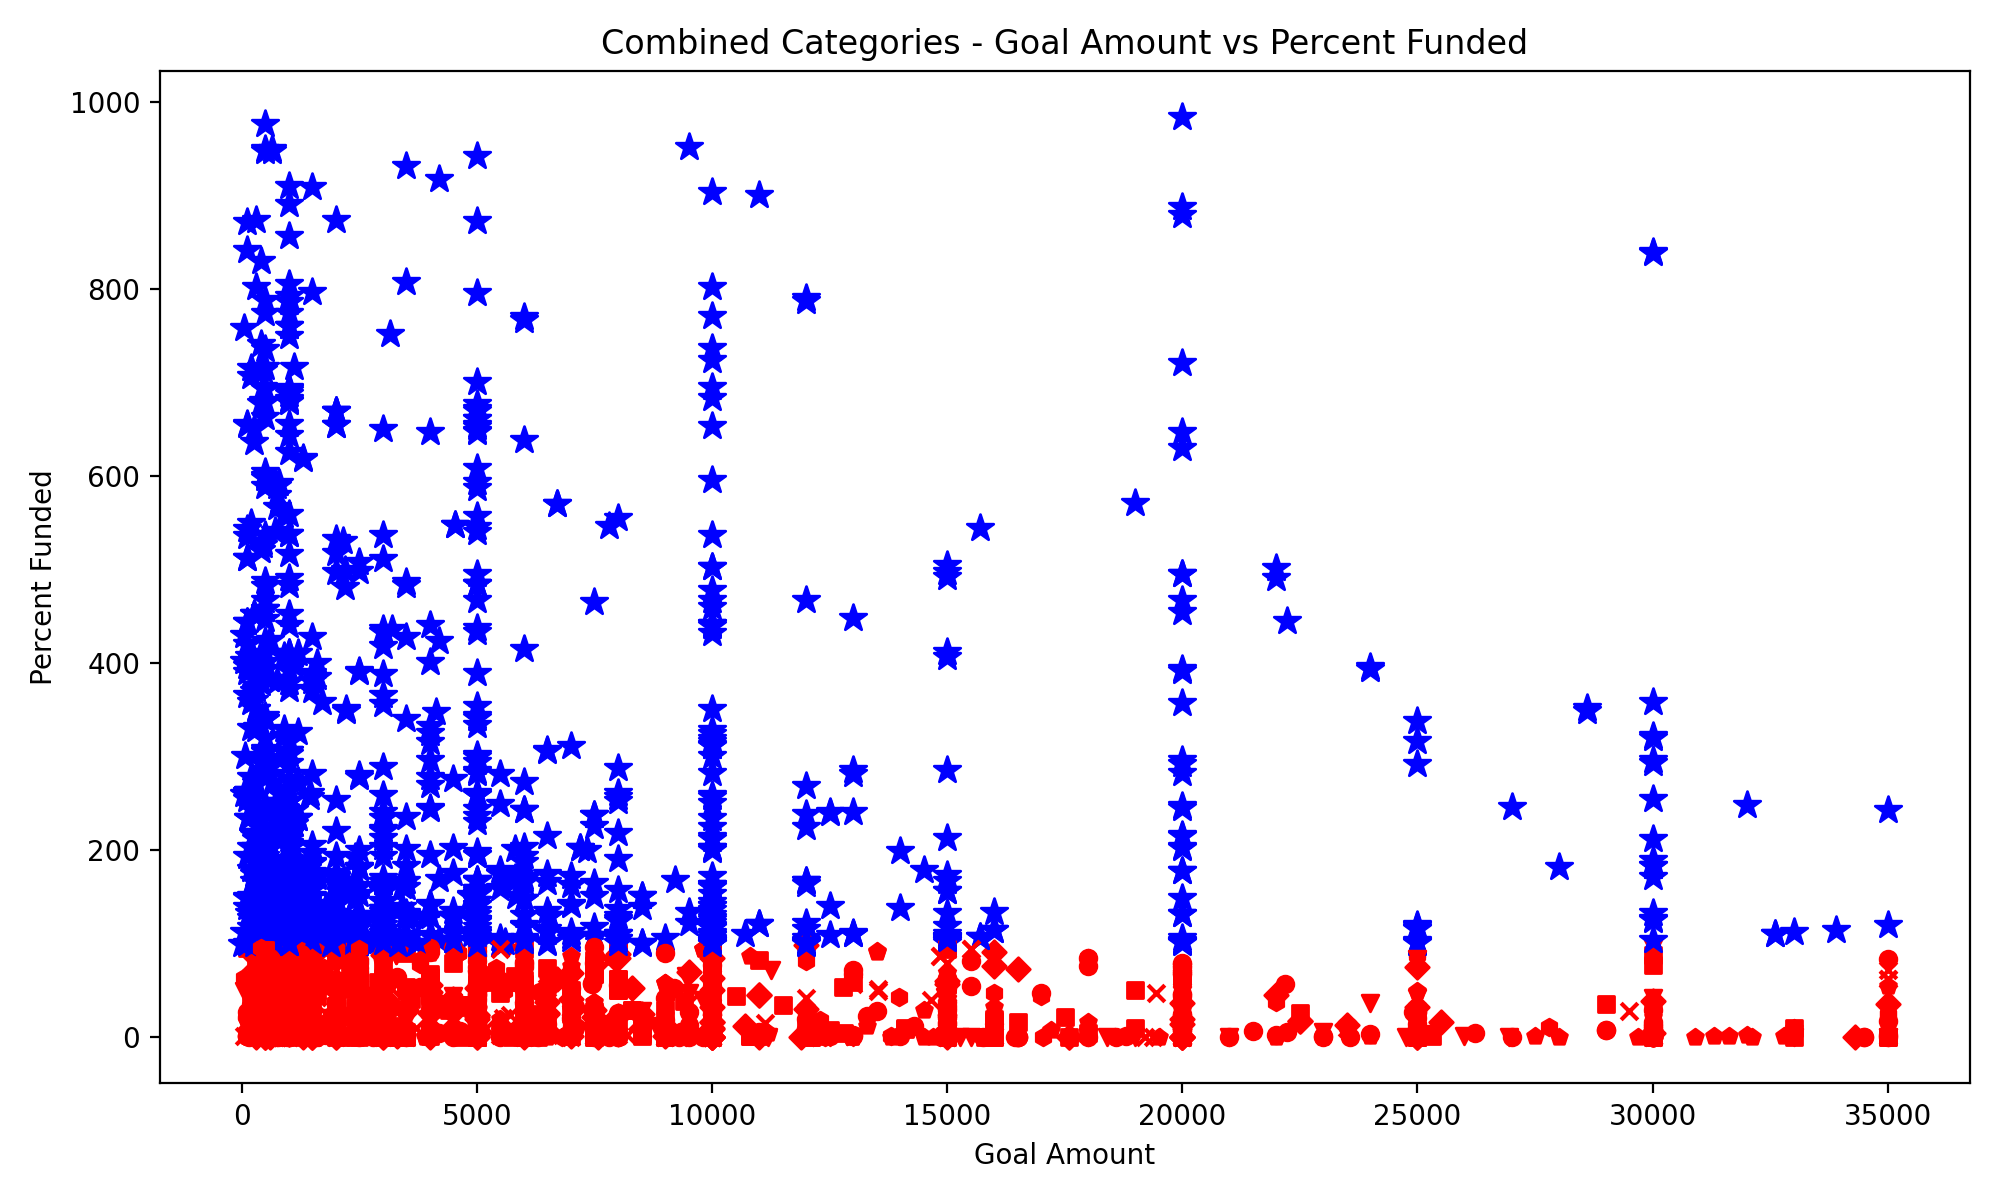

Parent Category: Comics
Coefficient: -0.007904706351716313
Intercept: 193.29696354633418
Sum of Squared Errors (SSE): 7719088.0111
Coefficient of Determination (R-squared): 0.0445
Parent Category: Fashion
Coefficient: -0.005754787145859301
Intercept: 140.5301966531577
Sum of Squared Errors (SSE): 2593074.4508
Coefficient of Determination (R-squared): 0.0957
Parent Category: Photography
Coefficient: -0.0005762317059756546
Intercept: 53.401380978132
Sum of Squared Errors (SSE): 46089.7885
Coefficient of Determination (R-squared): 0.0191
Parent Category: Film & Video
Coefficient: -0.0011133557102332515
Intercept: 53.748974445386864
Sum of Squared Errors (SSE): 590874.0459
Coefficient of Determination (R-squared): 0.0325
Parent Category: Art
Coefficient: -0.003939437492893947
Intercept: 142.1879266542835
Sum of Squared Errors (SSE): 4942483.8308
Coefficient of Determination (R-squared): 0.0358
Parent Category: none
Coefficient: -0.0018514840545886739
Intercept: 90.54575748740584
Sum of Squ

In [47]:
run_linear_regression_model();

The decision tree model demonstrates the ability to predict project success or failure based on the 'Goal Amount' and 'Duration' features. The obtained accuracy scores of approximately 65% on both the training and test data suggest that these variables contain valuable information that contributes to accurate predictions.
From the above, we can infer that effective goal setting and proper resource allocation, as represented by the 'Goal Amount', are crucial for project outcomes. Additionally, the 'Duration' of a project plays a significant role, indicating that the project's timeline can affect its chances of success.



Accuracy on training data =  0.6545209176788124
Accuracy on test data =  0.6492805755395683


<IPython.core.display.Javascript object>


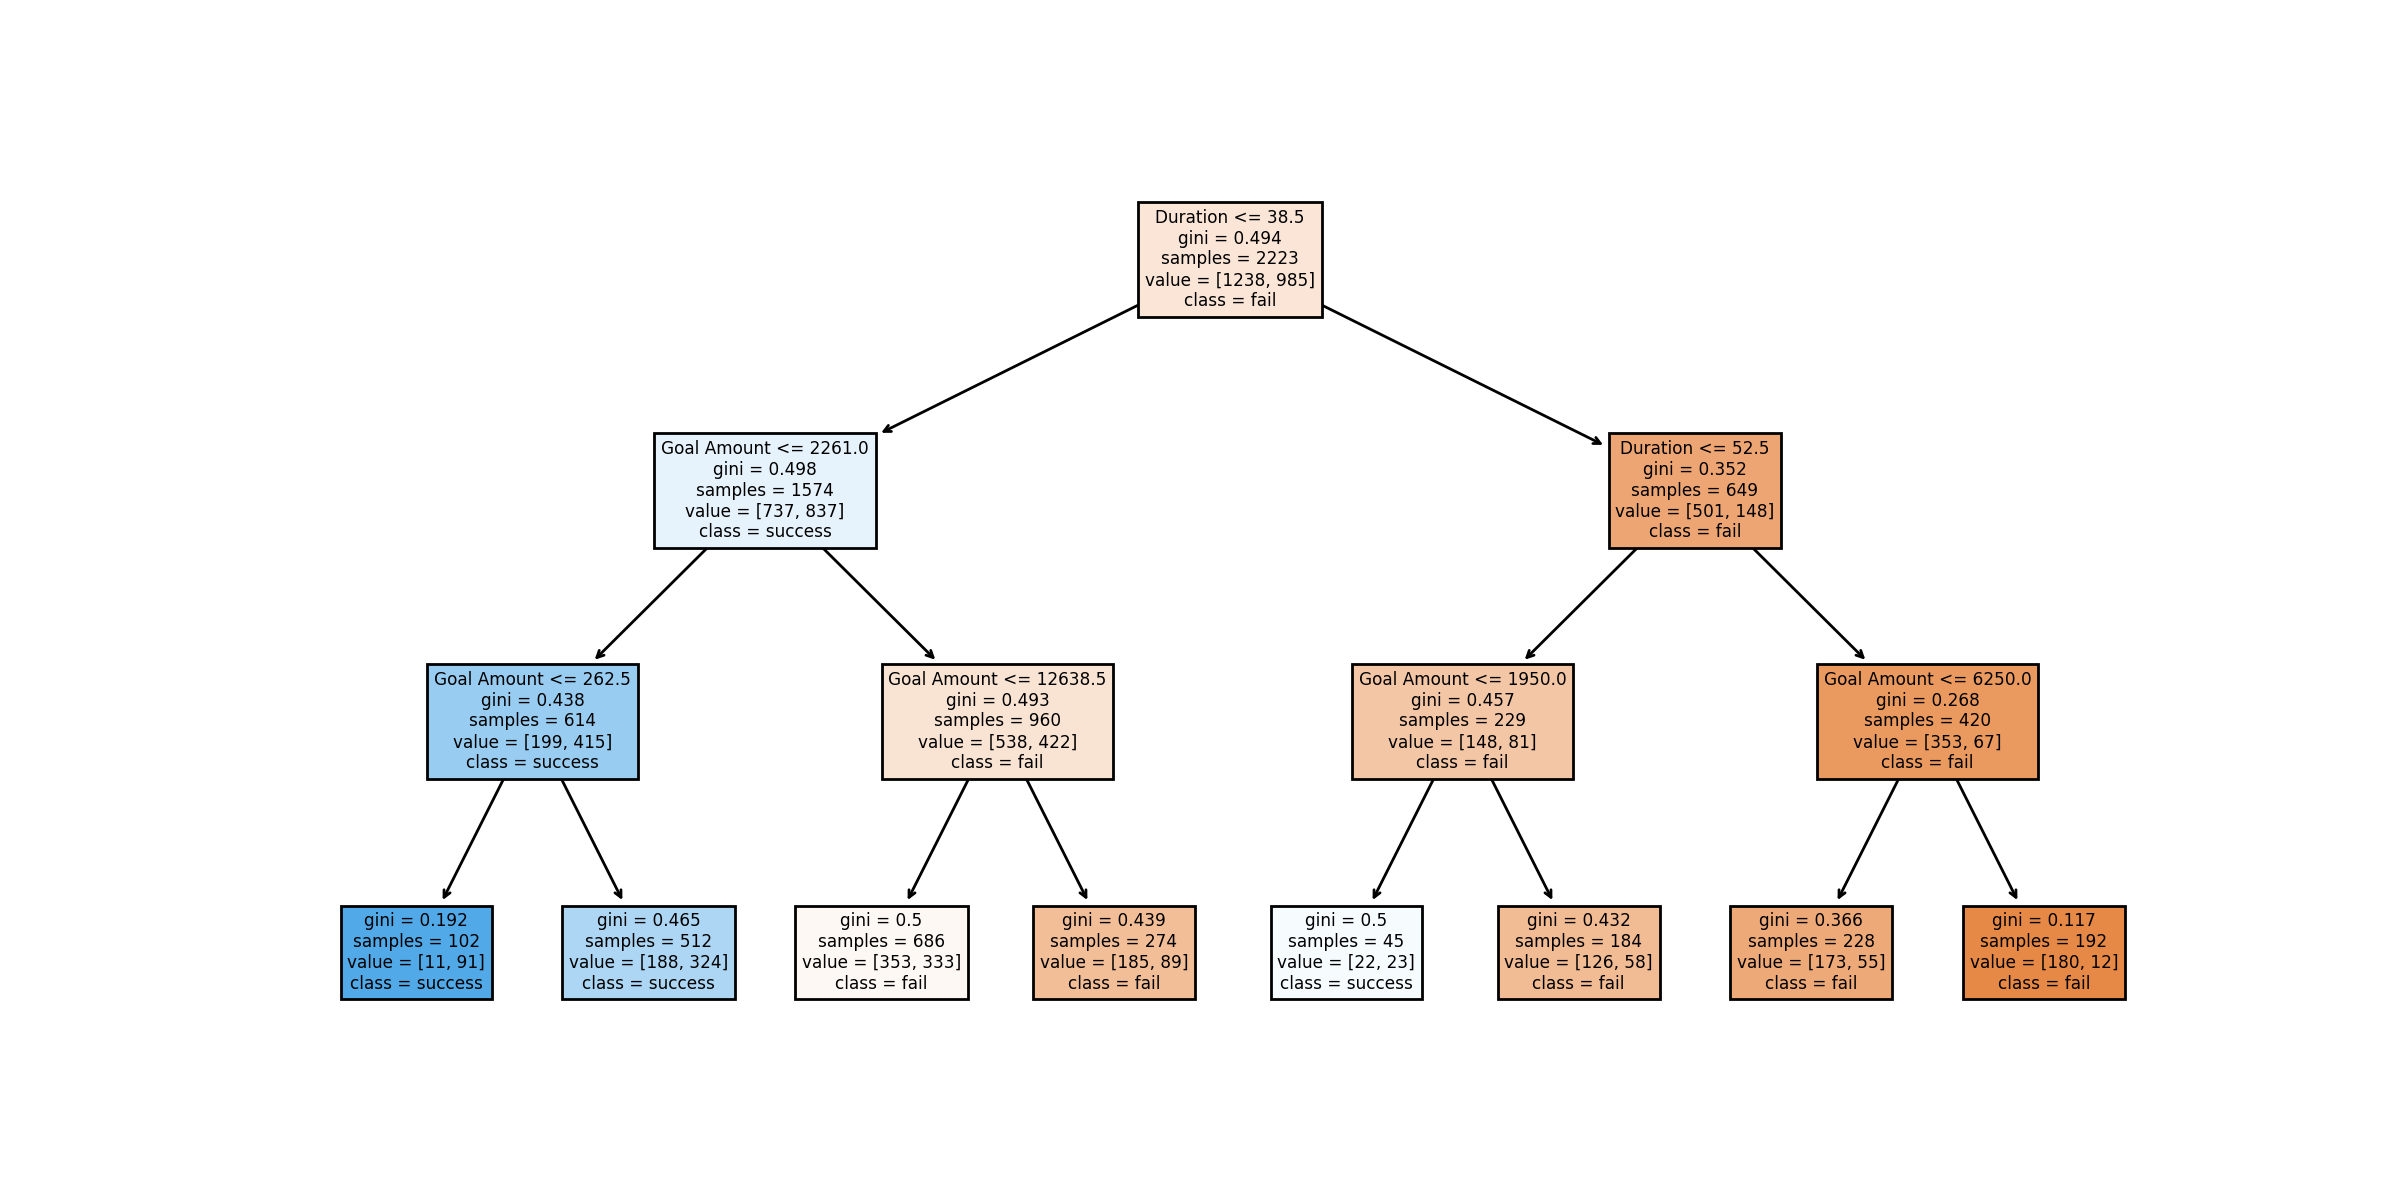

In [48]:
run_decision_tree_model();

The improved decision tree model demonstrates enhanced predictive capabilities compared to the previous version. By incorporating additional features such as 'Is Project We Love', 'Image Count', and adjusting the maximum depth to 4, the model achieved higher accuracy scores. The accuracy on the training data increased to 73.5%, while the accuracy on the test data reached 71.2%.

These improved accuracy scores suggest that the added features, along with the adjusted model complexity, contribute to a better understanding of the underlying patterns and relationships within the dataset. The inclusion of 'Is Project We Love' indicates that projects receiving special recognition or endorsement may have a higher likelihood of success. 'Image Count' could potentially reflect the visual appeal or quality of project presentations, which could influence backers' decisions. The adjusted maximum depth allows for more complex decision-making processes, enabling the model to capture a greater level of detail in predicting project outcomes.

Accuracy on training data =  0.7350427350427351
Accuracy on test data =  0.7122302158273381


<IPython.core.display.Javascript object>


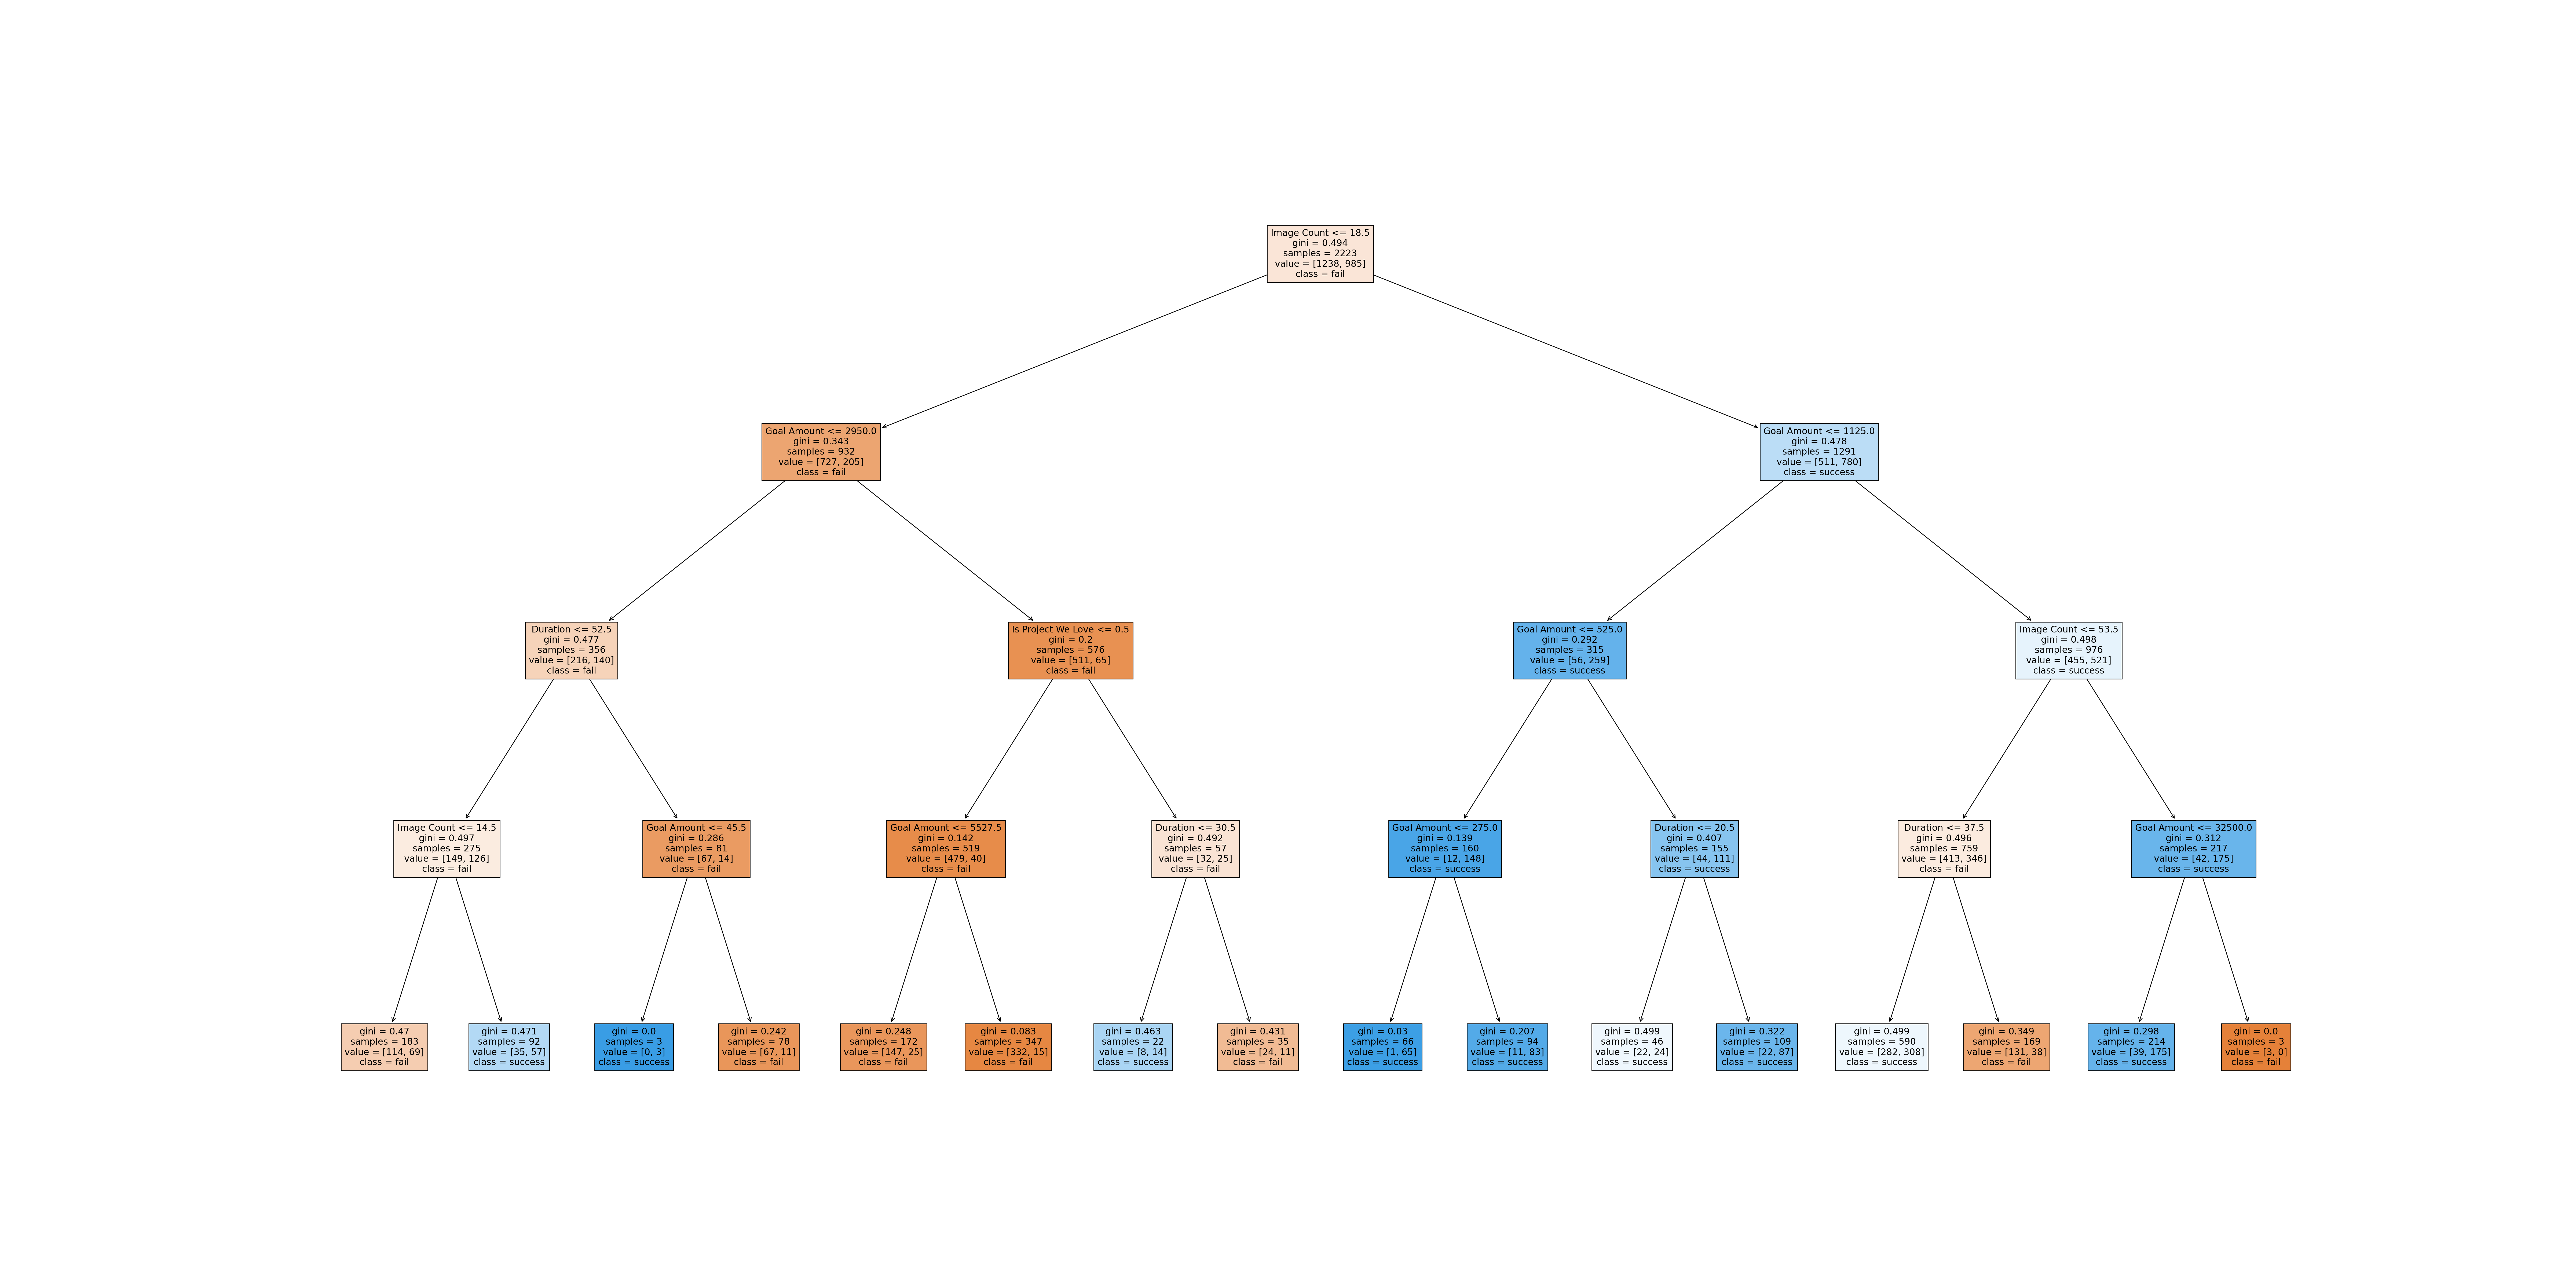

In [49]:
run_improved_decision_tree_model();

# Conclusion

This research aimed to understand what factors contribute to the success or failure of projects on the Kickstarter platform. We analyzed project characteristics and funding details to find out what makes a project more likely to succeed.

Our findings showed that several factors play a significant role in project outcomes. These factors include the length of the project duration, whether it received the "Project We Love" designation, the number of images included in the project, and the goal amount set by the creator.

The research highlights the importance of carefully considering these factors when launching a project. By paying attention to project duration, image count, "Project We Love" status, and goal amount, creators can make informed decisions to improve their chances of reaching their funding goals. For entrepreneurs looking to succeed with their ventures, it is crucial to match the goal amount with the category of the project. Additionally, including an adequate number of images on the project page can positively impact its success. Striving to earn the "Project We Love" distinction, which is related to the number of images used, can also increase the chances of success. Furthermore, it is advisable to provide a project description that is longer than 78 characters, as shorter descriptions have been associated with lower success rates.

In conclusion, this research sheds light on the dynamics of Kickstarter projects and provides valuable guidance for project creators seeking funding through crowdfunding platforms. By considering the identified factors, entrepreneurs can optimize their chances of success on Kickstarter and improve their prospects of securing the necessary funds for their projects.